In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from monai.networks.nets import UNet
from monai.losses import FocalLoss, DiceLoss
import qim3d

%matplotlib inline

In [3]:
# Define function for getting dataset path from string
def get_dataset_path(name: str):
    datasets = [
        'belialev2020_side',
        'gaudez2022_3d',
        'guo2023_2d',
        'stan2020_2d',
        'reichardt2021_2d',
        'testcircles_2dbinary',
    ]
    assert name in datasets, 'Dataset name must be ' + ' or '.join(datasets)

    dataset_idx = datasets.index(name)

    datasets_path = [
        '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Belialev2020/side',
        '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Gaudez2022/3d',
        '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Guo2023/2d/',
        '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Stan2020/2d',
        '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/Reichardt2021/2d',
        '/dtu/3d-imaging-center/projects/2023_STUDIOS_SD/analysis/data/TestCircles/2d_binary'
    ]

    return datasets_path[dataset_idx]

# Data loading

### Check out https://albumentations.ai/docs/getting_started/transforms_and_targets/

In [4]:
my_aug = qim3d.qim3d.utils.Augmentation()

In [5]:
aug_train = my_aug.augment('heavy')
aug_val_test = my_aug.augment(None)

In [6]:
### Possible datasets ####

# 'belialev2020_side'
# 'gaudez2022_3d'
# 'guo2023_2d'
# 'stan2020_2d'
# 'reichardt2021_2d'
# 'testcircles_2dbinary'

# Choose dataset
dataset = 'testcircles_2dbinary'

# Define class instances. First, both train and validation set is defined from train 
# folder with different transformations and below divided into non-overlapping subsets
train_set = qim3d.qim3d.utils.Dataset(root_path=get_dataset_path(dataset),transform=aug_train)
val_set = qim3d.qim3d.utils.Dataset(root_path=get_dataset_path(dataset),transform=aug_val_test)
test_set = qim3d.qim3d.utils.Dataset(root_path=get_dataset_path(dataset),split='test',transform=aug_val_test)

# Define fraction of training set used for validation
VAL_FRACTION = 0.3
split_idx = int(np.floor(VAL_FRACTION * len(train_set)))

# Define seed
# torch.manual_seed(42)

# Get randomly permuted indices 
indices = torch.randperm(len(train_set))

# Define train and validation sets as subsets
train_set = torch.utils.data.Subset(train_set, indices[split_idx:])
val_set = torch.utils.data.Subset(val_set, indices[:split_idx])

### Data overview

In [7]:
# Check if data has mask
has_mask= False #True if train_set[0][-1] is not None else False

print(f'No. of train images={len(train_set)}')
print(f'No. of validation images={len(val_set)}')
print(f'No. of test images={len(test_set)}')
print(f'{train_set[0][0].dtype=}')
print(f'{train_set[0][1].dtype=}')
print(f'image shape={train_set[0][0].shape}')
print(f'label shape={train_set[0][1].shape}')
print(f'Labels={np.unique(train_set[0][1])}')
print(f'Masked data? {has_mask}')

No. of train images=32
No. of validation images=13
No. of test images=12
train_set[0][0].dtype=torch.float32
train_set[0][1].dtype=torch.uint8
image shape=torch.Size([1, 256, 256])
label shape=torch.Size([256, 256])
Labels=[0 1]
Masked data? False


### Data visualization

Display first seven image, labels, and masks if they exist

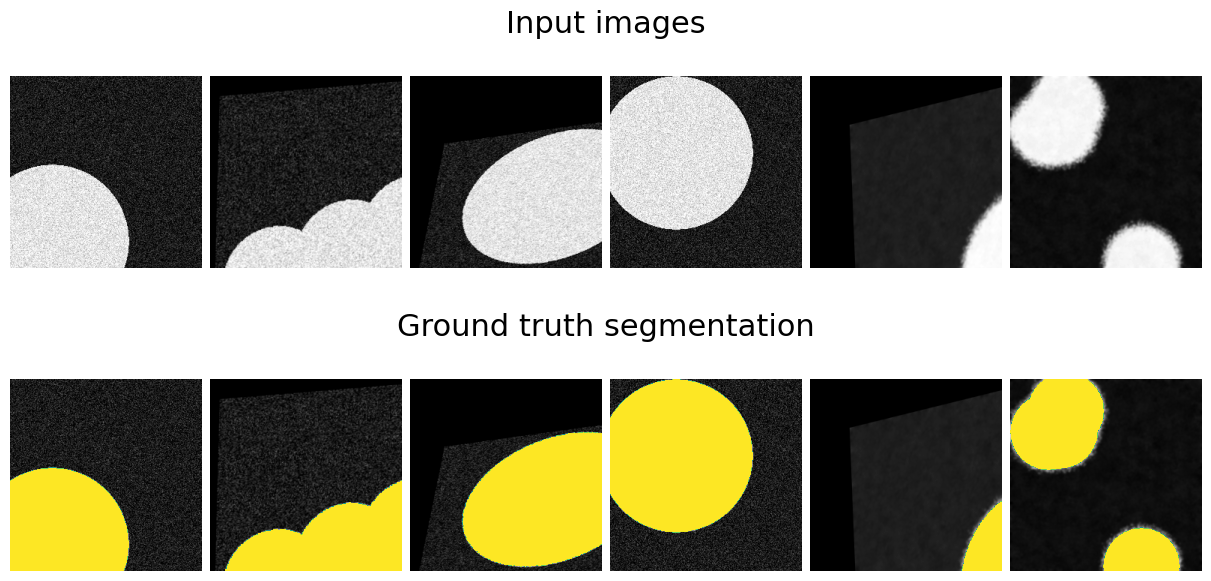

In [8]:
qim3d.qim3d.viz.grid_overview(train_set,num_images=6,alpha=1)

In [9]:
# Define batch sizes
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

# Define dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=VAL_BATCH_SIZE, num_workers=8, pin_memory=True)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, num_workers=8, pin_memory=True)

In [10]:
train_loader

# Train U-Net

In [11]:
# Define model
model = UNet(
    spatial_dims=2,
    in_channels=1, 
    out_channels=1, 
    channels=(64, 128, 256, 512, 1024), 
    strides=(2, 2, 2, 2), 
)

orig_state = model.state_dict()  # Save, so we can reset model to original state later

# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = FocalLoss()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Run training

In [12]:
# Define hyperparameters
NUM_EPOCHS = 2
EVAL_EVERY = 1
PRINT_EVERY = 1
LR = 3e-3


model.load_state_dict(orig_state)  # Restart training every time
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

all_losses = []
all_val_loss = []
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    for data in train_loader:
        if has_mask:
            inputs, targets, masks = data
            masks = masks.to(device).float()
        else:
            inputs, targets = data

        inputs = inputs.to(device)
        targets = targets.to(device).float().unsqueeze(1)
        
        # Forward -> Backward -> Step
        optimizer.zero_grad()

        outputs = model(inputs)

        #print(f'input {inputs.shape}, target: {targets.shape}, output: {outputs.shape}')
    
        loss = loss_fn(outputs*masks, targets*masks) if has_mask else loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach()
        step += 1
        
    # Log and store average epoch loss
    epoch_loss = epoch_loss.item() / step
    all_losses.append(epoch_loss)

    if epoch % EVAL_EVERY == 0:
        model.eval()
        with torch.no_grad():  # Do not need gradients for this part
            loss_sum = 0
            step = 0
            for data in val_loader:
                if has_mask:
                    inputs, targets, masks = data
                    masks = masks.to(device).float()
                else:
                    inputs, targets = data
                
                inputs = inputs.to(device)
                targets = targets.to(device).float().unsqueeze(1)
                
                outputs = model(inputs)
                
                loss_sum += loss_fn(outputs*masks, targets*masks) if has_mask else loss_fn(outputs, targets)
                step += 1
                
            val_loss = loss_sum.item() / step
            all_val_loss.append(val_loss)

        # Log and store average accuracy
        if epoch % PRINT_EVERY == 0:
            print(f'Epoch {epoch: 3}, train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}')

print('Min val loss:', min(all_val_loss))

Epoch   0, train loss: 0.2011, val loss: 0.0122
Epoch   1, train loss: 0.0157, val loss: 0.0051
Min val loss: 0.005074315704405308


### Plot train and validation loss

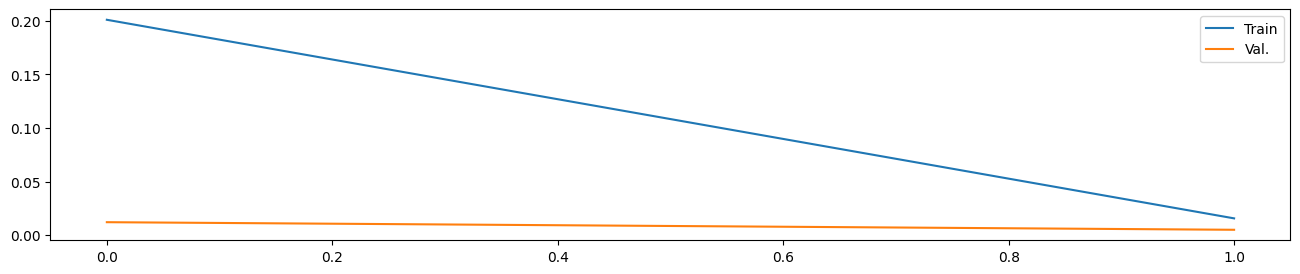

In [13]:
plt.figure(figsize=(16, 3))
plt.plot(all_losses, '-', label='Train')
plt.plot(all_val_loss, '-', label='Val.')
plt.legend()
plt.show()

### Inspecting the Predicted Segmentations on training data

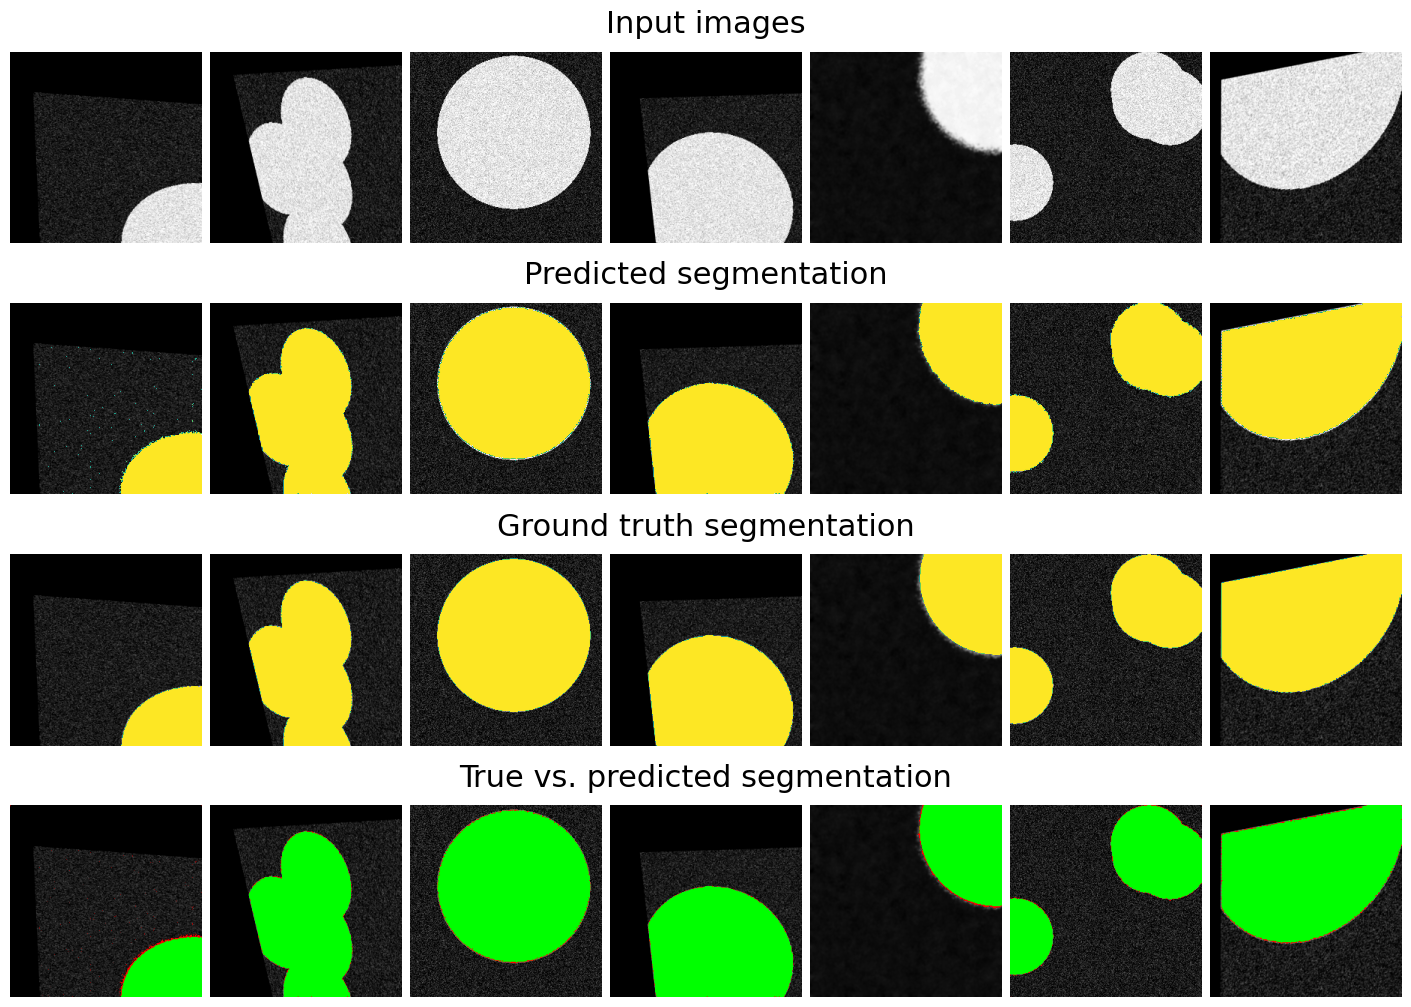

In [14]:
in_targ_preds_train = qim3d.utils.models.inference(train_set,model)
qim3d.qim3d.viz.grid_pred(in_targ_preds_train,alpha=1)

### Inspecting the Predicted Segmentations on test data

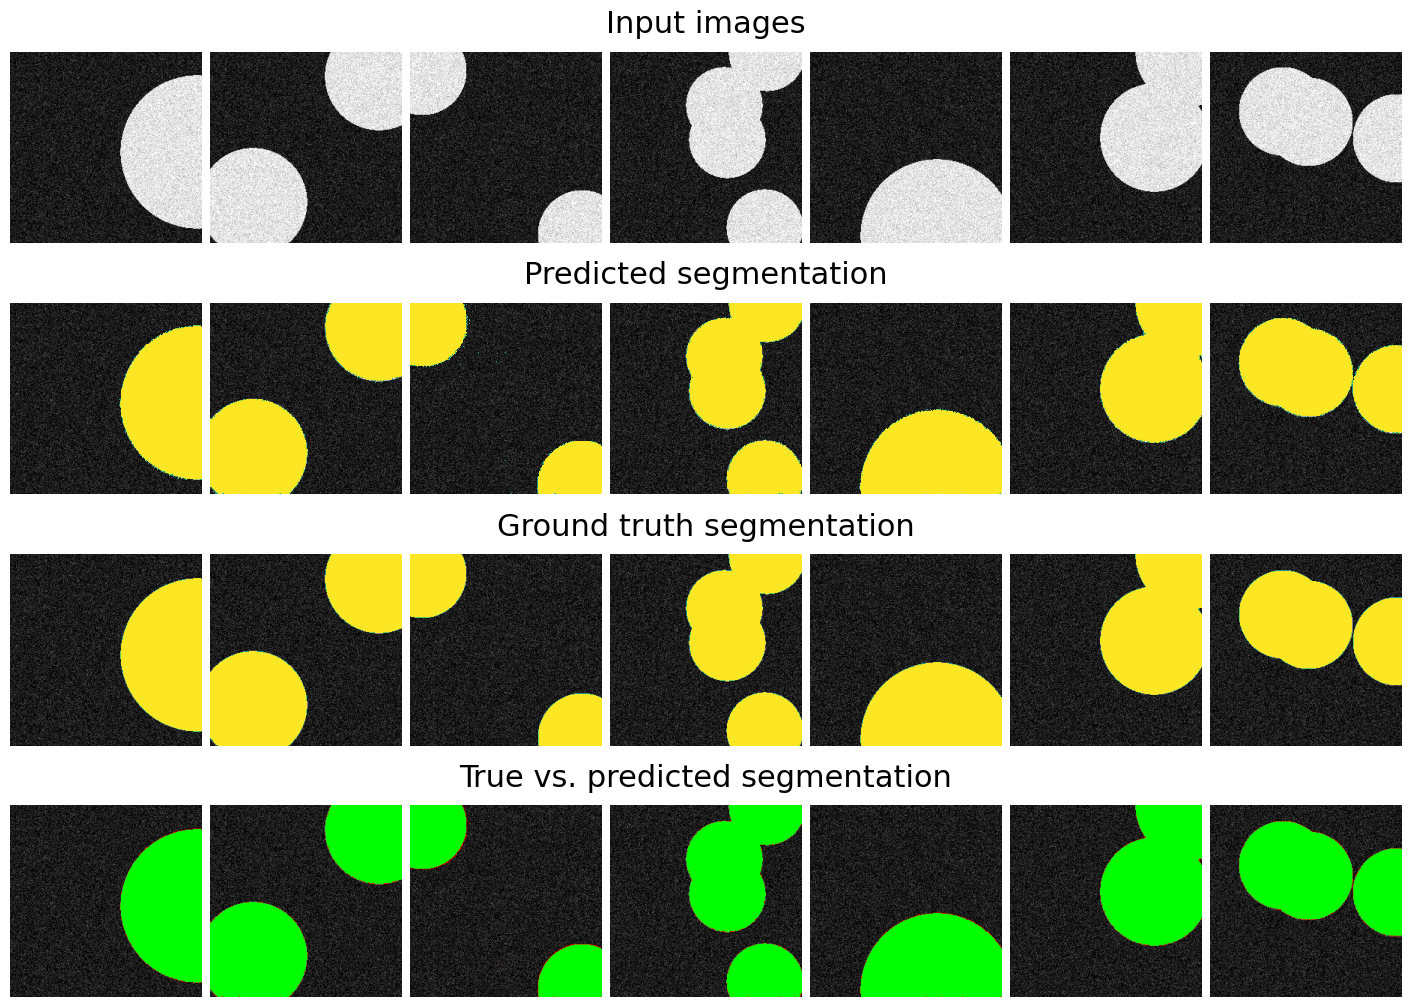

In [15]:
in_targ_preds_test = qim3d.utils.models.inference(test_set,model)
qim3d.qim3d.viz.grid_pred(in_targ_preds_test,alpha=1)